In [2]:
from make_sins_dataset import *

if __name__ == "__main__":
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # TODO: fill this with your desired path:
    OUT_DIR = "/home/tavakoli/DiffPM/src/data2.0"   # e.g., OUT_DIR = "/path/to/Data" (same folder Diffusion-TS expects)
    # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    if not OUT_DIR:
        raise SystemExit("Please set OUT_DIR to a directory path before running.")
    make_sines(OUT_DIR)

[OK] Saved Sines dataset to: /home/tavakoli/DiffPM/src/data2.0
     train: (10000, 24, 5)  test: (1000, 24, 5)
     scale mins: [-1.4995152 -1.4995801 -1.4993395 -1.4997209 -1.499796 ]  maxs: [1.4997427 1.4998142 1.4998486 1.499265  1.4992217]



=== Shapes & stats ===
    GT train: shape=(10000, 24, 5) | per-feat min=[-1.4995152 -1.4995801 -1.4993395 -1.4997209 -1.499796 ] | max=[1.4997427 1.4998142 1.4998486 1.499265  1.4992217] | mean=[ 0.00018909 -0.00151985  0.0028247  -0.0029244   0.00310977]
     GT test: shape=(1000, 24, 5) | per-feat min=[-1.4983828 -1.4999975 -1.4998946 -1.4942367 -1.4978925] | max=[1.4990425 1.497525  1.4984139 1.4966725 1.4994923] | mean=[-0.00739199  0.0042547  -0.01010379  0.00822395  0.00861712]
  NORM train: shape=(10000, 24, 5) | per-feat min=[-1. -1. -1. -1. -1.] | max=[1. 1. 1. 1. 1.] | mean=[ 5.0177510e-05 -1.0914701e-03  1.7139012e-03 -1.7981766e-03
  2.2653770e-03]
   NORM test: shape=(1000, 24, 5) | per-feat min=[-0.9992449  -1.0002782  -1.0003703  -0.9963426  -0.99873054] | max=[0.99953294 0.9984735  0.99904335 0.9982712  1.0001805 ] | mean=[-0.00500509  0.00275897 -0.00690739  0.00563661  0.00593818]


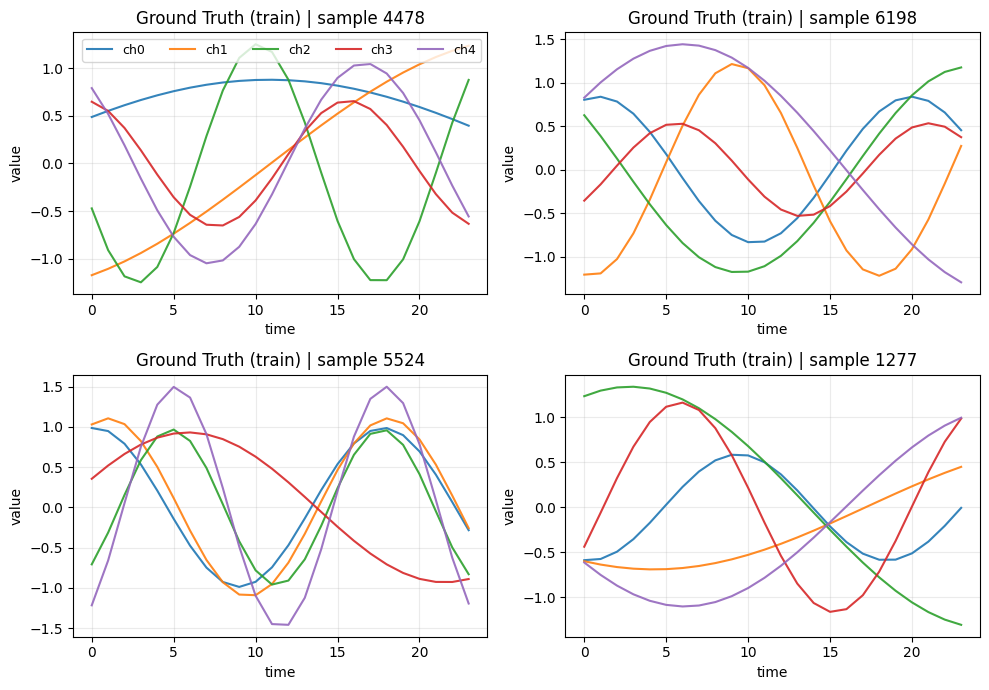

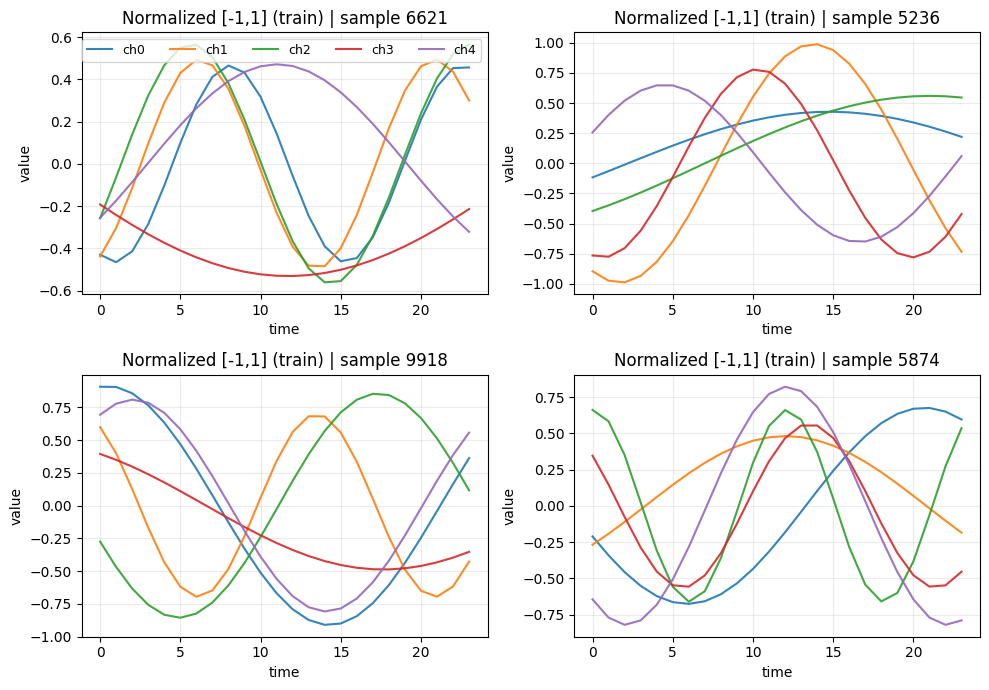

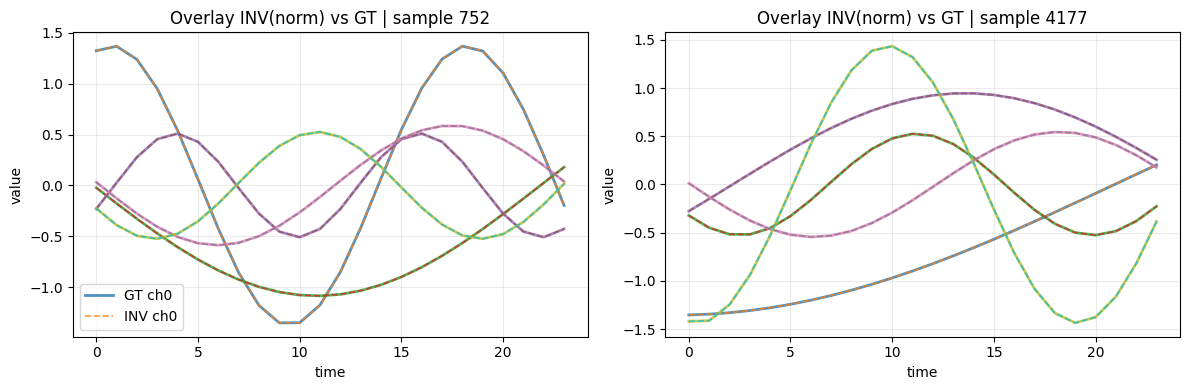

In [4]:
# visualize_sines.py
# Read & visualize Sines dataset saved by make_sines_dataset.py

import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

# ==== PATHS (edit if needed) ====
DATA_DIR = "/home/tavakoli/DiffPM/src/data2.0"  # <- your path
SEQ_LEN  = 24                                   # must match generation
PREFIX   = "sines"                              # file name prefix

GT_TRAIN   = os.path.join(DATA_DIR, f"{PREFIX}_ground_truth_{SEQ_LEN}_train.npy")
GT_TEST    = os.path.join(DATA_DIR, f"{PREFIX}_ground_truth_{SEQ_LEN}_test.npy")
NORM_TRAIN = os.path.join(DATA_DIR, f"{PREFIX}_norm_truth_{SEQ_LEN}_train.npy")
NORM_TEST  = os.path.join(DATA_DIR, f"{PREFIX}_norm_truth_{SEQ_LEN}_test.npy")
SCALE_NPZ  = os.path.join(DATA_DIR, f"{PREFIX}_scale_{SEQ_LEN}.npz")

def load_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    gt_tr   = np.load(GT_TRAIN)    # (N, L, D)
    gt_te   = np.load(GT_TEST)
    norm_tr = np.load(NORM_TRAIN)
    norm_te = np.load(NORM_TEST)
    return gt_tr, gt_te, norm_tr, norm_te

def load_scale() -> Optional[Tuple[np.ndarray, np.ndarray]]:
    if os.path.exists(SCALE_NPZ):
        z = np.load(SCALE_NPZ)
        return z["mins"].astype(np.float32), z["maxs"].astype(np.float32)
    return None

def inv_minmax_neg1to1(x_norm: np.ndarray, mins: np.ndarray, maxs: np.ndarray) -> np.ndarray:
    # x_norm in [-1, 1]  -> [0,1] -> original
    x01 = (x_norm + 1.0) * 0.5
    return x01 * (maxs[None, None, :] - mins[None, None, :]) + mins[None, None, :]

def describe_split(name: str, arr: np.ndarray):
    N, L, D = arr.shape
    flat = arr.reshape(-1, D)
    print(f"{name:>12}: shape={arr.shape} | per-feat min={flat.min(0)} | max={flat.max(0)} | mean={flat.mean(0)}")

def plot_windows(arr: np.ndarray, title: str, n_show: int = 4, random_pick: bool = True):
    N, L, D = arr.shape
    if N == 0:
        print(f"[WARN] No samples to plot for {title}")
        return
    idxs = np.random.choice(N, size=min(n_show, N), replace=False) if random_pick else np.arange(min(n_show, N))
    cols = min(2, len(idxs))
    rows = int(np.ceil(len(idxs) / cols))
    t = np.arange(L)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 3.5 * rows), squeeze=False)
    axes = axes.ravel()
    for k, i in enumerate(idxs):
        ax = axes[k]
        for d in range(D):
            ax.plot(t, arr[i, :, d], alpha=0.9, lw=1.5, label=f"ch{d}" if k == 0 else None)
        ax.set_title(f"{title} | sample {i}")
        ax.set_xlabel("time")
        ax.set_ylabel("value")
        if k == 0:
            ax.legend(ncol=min(D, 5), fontsize=9)
        ax.grid(alpha=0.25)
    # hide any extra axes
    for a in axes[len(idxs):]:
        a.axis("off")
    plt.tight_layout()
    plt.show()

def overlay_invscaled(norm_arr: np.ndarray, gt_arr: np.ndarray, mins: np.ndarray, maxs: np.ndarray,
                      title: str, n_show: int = 2):
    """Overlay inverse-scaled normalized samples with ground-truth to sanity-check scaling."""
    N, L, D = norm_arr.shape
    idxs = np.random.choice(N, size=min(n_show, N), replace=False)
    t = np.arange(L)
    fig, axes = plt.subplots(1, len(idxs), figsize=(6 * len(idxs), 4), squeeze=False)
    axes = axes.ravel()
    for k, i in enumerate(idxs):
        ax = axes[k]
        inv = inv_minmax_neg1to1(norm_arr[i:i+1], mins, maxs).squeeze(0)  # (L, D)
        for d in range(D):
            ax.plot(t, gt_arr[i, :, d],  lw=2.0, alpha=0.8, label=f"GT ch{d}" if k == 0 and d == 0 else None)
            ax.plot(t, inv[:, d],       lw=1.2, alpha=0.8, linestyle="--", label=f"INV ch{d}" if k == 0 and d == 0 else None)
        ax.set_title(f"{title} | sample {i}")
        ax.set_xlabel("time"); ax.set_ylabel("value"); ax.grid(alpha=0.25)
    if len(idxs) > 0:
        axes[0].legend(loc="best")
    plt.tight_layout()
    plt.show()

def main():
    # Load
    gt_tr, gt_te, norm_tr, norm_te = load_data()
    print("\n=== Shapes & stats ===")
    describe_split("GT train",   gt_tr)
    describe_split("GT test",    gt_te)
    describe_split("NORM train", norm_tr)
    describe_split("NORM test",  norm_te)

    # Quick shape sanity
    assert gt_tr.shape[1] == SEQ_LEN and gt_te.shape[1] == SEQ_LEN, "SEQ_LEN mismatch with ground truth arrays."
    assert norm_tr.shape[1] == SEQ_LEN and norm_te.shape[1] == SEQ_LEN, "SEQ_LEN mismatch with normalized arrays."
    assert gt_tr.shape[2] == norm_tr.shape[2], "Channel count mismatch."

    # Plot a few windows (all channels)
    plot_windows(gt_tr,   title="Ground Truth (train)", n_show=4, random_pick=True)
    plot_windows(norm_tr, title="Normalized [-1,1] (train)", n_show=4, random_pick=True)

    # If scale is present, overlay inverse-scaled normalized with ground truth
    scale = load_scale()
    if scale is not None:
        mins, maxs = scale
        overlay_invscaled(norm_tr, gt_tr, mins, maxs, title="Overlay INV(norm) vs GT", n_show=2)
    else:
        print("[INFO] No scale file found; skipping inverse-scaling overlay.")

if __name__ == "__main__":
    main()
